# PyTorch Tutorial for DSC Tetris RL Project Group

In [188]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

## Linear Regression with Gradient Descent

We make a linear regression model of the form $\hat{y} = \hat{\beta_0} + \hat{\beta_1}x_1 + \hat{\beta_2}x_2$. First let's define the model.

In [189]:
class OLS(nn.Module):
    def __init__(self):
        super(OLS, self).__init__()
        self.weights = nn.Linear(2, 1) # slope1, slope2, intercept
    
    def forward(self, x):
        return self.weights(x)

Now we make some fake data to test it out.

In [190]:
X = torch.Tensor([
    [1, 2],
    [3, 4],
    [5, 6],
    [4, 2],
    [10,9]
])

# y = 1.62 + 3.14x_1 + 1.41x_2
y = torch.sum(X*torch.Tensor([3.14, 1.41]), axis=1, keepdims=True) + 1.62 # 5x1
X, y

(tensor([[ 1.,  2.],
         [ 3.,  4.],
         [ 5.,  6.],
         [ 4.,  2.],
         [10.,  9.]]),
 tensor([[ 7.5800],
         [16.6800],
         [25.7800],
         [17.0000],
         [45.7100]]))

Now initialize the model, optimizer, loss function, and train the model.

In [191]:
model = OLS()
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

num_steps = 1000

for step in range(num_steps):
    optimizer.zero_grad()
    y_ = model(X) # predicted
    loss = criterion(y_, y)
    loss.backward()
    optimizer.step()
    
    if step % 100 == 0:
        print(f"Step: {step}, Loss: {loss.item()}")

Step: 0, Loss: 874.3859252929688
Step: 100, Loss: 0.3385462164878845
Step: 200, Loss: 0.11772467195987701
Step: 300, Loss: 0.04475127160549164
Step: 400, Loss: 0.017174752429127693
Step: 500, Loss: 0.006597722880542278
Step: 600, Loss: 0.00253481836989522
Step: 700, Loss: 0.0009739218512549996
Step: 800, Loss: 0.0003741784894373268
Step: 900, Loss: 0.00014376426406670362


Look at the predictions and the expected output.

In [192]:
model(X), y

(tensor([[ 7.5711],
         [16.6760],
         [25.7809],
         [16.9882],
         [45.7163]], grad_fn=<AddmmBackward>),
 tensor([[ 7.5800],
         [16.6800],
         [25.7800],
         [17.0000],
         [45.7100]]))

Look at the predicted weights (they should be close to what we used to make the $y$ data):

In [193]:
model.weights.weight, model.weights.bias

(Parameter containing:
 tensor([[3.1390, 1.4134]], requires_grad=True),
 Parameter containing:
 tensor([1.6052], requires_grad=True))

## Finding the Highest Reward Path on a Lattice Using REINFORCE

In [194]:
board = np.array([
    [0, -1000000, -200000, -300000],
    [100000, 10000, -1000000, -400000],
    [-10000, 10000, 10000, 10000],
    [-10000, -10000, -10000, 0]
])

In [195]:
# typical x: [r, c] --> max{0, b_0 + b_1r + b_2c} =: y, 
class Model(nn.Module):
    # expects 2D input
    # outputs logits of right and down
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(2, 3)
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3,optimizer.step() 2) # logit right, logit down
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x #logits

<IPython.core.display.Javascript object>


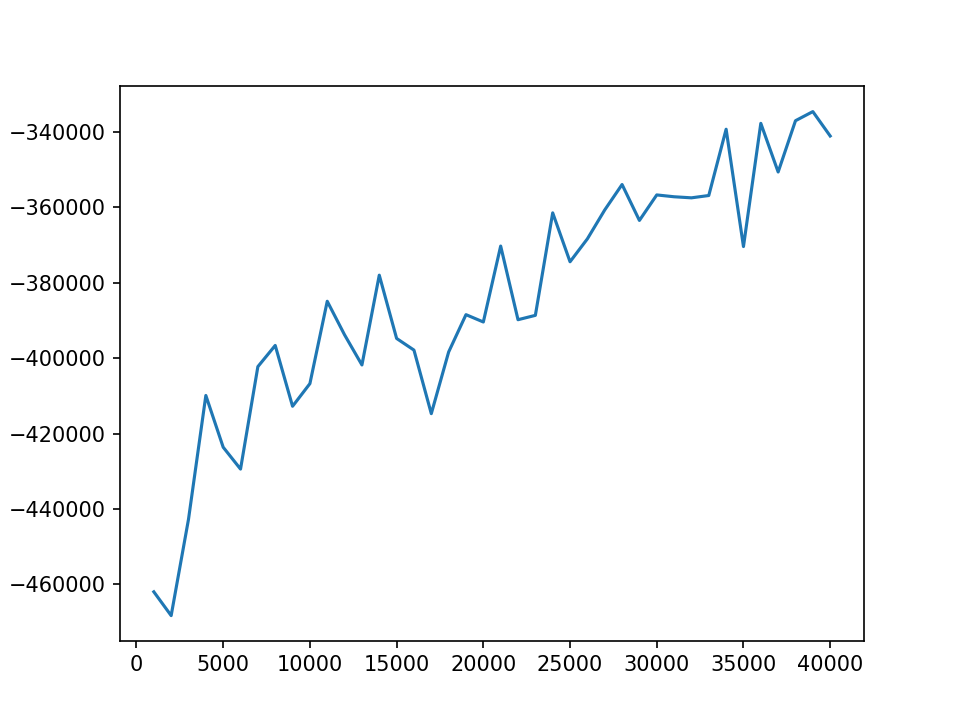

Model(
  (fc1): Linear(in_features=2, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=2, bias=True)
)

In [196]:
# just some constant vars
RIGHT, DOWN = 1, 0

# plotting stuff
plot_episode = []
plot_rewards = []

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()


gamma = 0.999
num_episodes = 40000
pool_size = 1000

model = Model()
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

state_pool = []
action_pool = []
reward_pool = []

for e in range(num_episodes):
    position = torch.zeros(1, 2)
    
    model.eval()
    # takes 6 steps to go from top left to bottom right
    for i in range(6):
        if position[0, RIGHT] == 3:
            # we are all the way right
            position = position.clone().detach()
            position[0, DOWN] += 1
        elif position[0, DOWN] == 3:
            # we are all the way down
            position = position.clone().detach()
            position[0, RIGHT] += 1
        else:
            prob_action = model(position)
            action = Categorical(logits = prob_action).sample() # [-1000, 199] --> softmax([-1000, 199])
            if action.item() == RIGHT:
                # move right
                position = position.clone().detach()
                position[0, RIGHT] += 1
            elif action.item() == DOWN:
                # move down
                position = position.clone().detach()
                position[0, DOWN] += 1
        
        reward = board[int(position[0, DOWN]), int(position[0, RIGHT])]
        
        state_pool.append(position)
        action_pool.append(action)
        reward_pool.append(reward)
    
    model.train()
    if e % pool_size == pool_size - 1:
        ax.clear()
        plot_episode.append(e)
        
        for i in reversed(range(len(reward_pool))):
            if reward_pool[i] == 0:
                prev_reward = 0
            else:
                prev_reward = prev_reward * gamma + reward_pool[i]
            reward_pool[i] = prev_reward
        
        reward_mean = np.mean(reward_pool)
        reward_std = np.std(reward_pool)
        
        # plot mean reward
        plot_rewards.append(reward_mean)
        ax.plot(plot_episode, plot_rewards)
        fig.canvas.draw()
        
        
        for i in range(len(reward_pool)):
            reward_pool[i] = (reward_pool[i] - reward_mean) / reward_std
        
        optimizer.zero_grad()
        for i in range(0, len(reward_pool), 6):
            state = torch.cat(state_pool[i:i+6])
            action = torch.tensor(action_pool[i:i+6]).long()
            reward = torch.tensor(reward_pool[i:i+6]).float()
            
            loss = torch.sum(-Categorical(logits = model(state)).log_prob(action) * reward)
            loss.backward()
        
        optimizer.step()
        
        state_pool = []
        action_pool = []
        reward_pool = []

model.eval()

In [197]:
position = torch.zeros(1, 2)
reward = 0

# takes 6 steps to go from top left to bottom right
for i in range(6):
    if position[0, RIGHT] == 3:
        # we are all the way right
        position[0, DOWN] += 1
    elif position[0, DOWN] == 3:
        # we are all the way down
        position[0, RIGHT] += 1
    else:
        prob_action = model(position)
        action = torch.argmax(prob_action)
        if action.item() == RIGHT:
            # move right
            position[0, RIGHT] += 1
        elif action.item() == DOWN:
            # move down
            position[0, DOWN] += 1
    reward += board[int(position[0, DOWN]), int(position[0, RIGHT])]
    print(position, reward)

tensor([[1., 0.]]) 100000
tensor([[2., 0.]]) 90000
tensor([[3., 0.]]) 80000
tensor([[3., 1.]]) 70000
tensor([[3., 2.]]) 60000
tensor([[3., 3.]]) 60000
